<center><h1>6. FILTERS,CANNY EDGE DETECTION, LoG AND DoG</h1></center>

In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h2>1)CANNY EDGE DETECTION</h2>

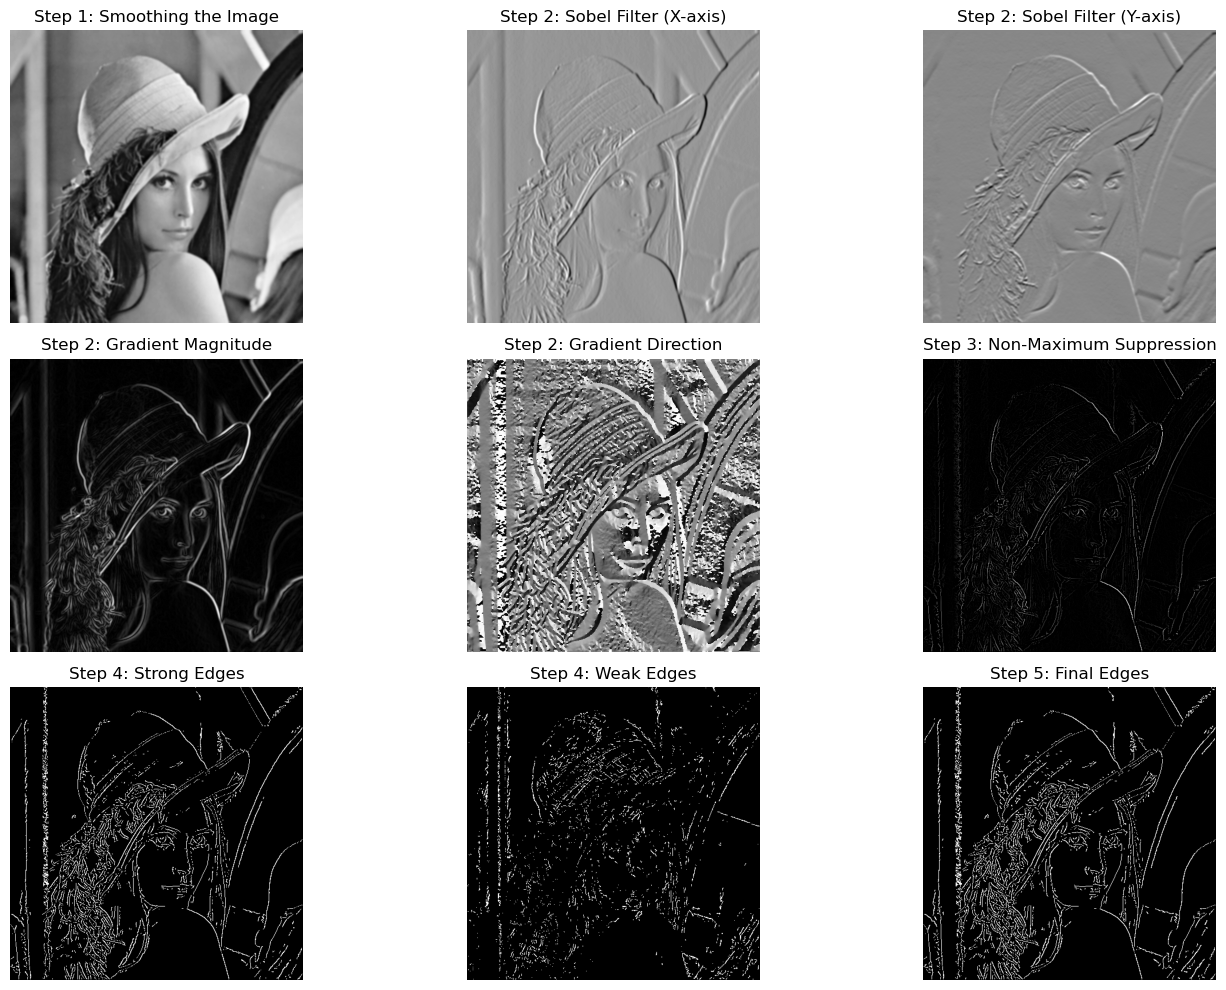

In [ ]:
def canny_edge_detection(image_path):
    # Step 1: Load Image and Apply Gaussian Blur
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_image = cv2.GaussianBlur(img, (5, 5), 1.4)
    
    # Step 2: Compute Gradients using Sobel Filters
    Gx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max() * 255).astype(np.uint8)
    
    direction = np.arctan2(Gy, Gx) * (180 / np.pi)
    direction = (direction - direction.min()) / (direction.max() - direction.min()) * 255  # Normalize to 0-255
    direction = direction.astype(np.uint8)
    
    # Step 3: Non-Maximum Suppression
    nms_result = np.zeros_like(gradient_magnitude, dtype=np.uint8)
    rows, cols = gradient_magnitude.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            q, r = 255, 255
            angle = direction[i, j] % 180
            
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q, r = gradient_magnitude[i, j+1], gradient_magnitude[i, j-1]
            elif 22.5 <= angle < 67.5:
                q, r = gradient_magnitude[i+1, j-1], gradient_magnitude[i-1, j+1]
            elif 67.5 <= angle < 112.5:
                q, r = gradient_magnitude[i+1, j], gradient_magnitude[i-1, j]
            elif 112.5 <= angle < 157.5:
                q, r = gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]
            
            nms_result[i, j] = gradient_magnitude[i, j] if (gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r) else 0
    
    # Step 4: Double Thresholding
    high_threshold = np.max(nms_result) * 0.1  # Reduced to 10% of max intensity
    low_threshold = high_threshold * 0.5       # Half of high threshold
    
    strong_edges = np.zeros_like(nms_result)
    weak_edges = np.zeros_like(nms_result)
    
    strong_edges[nms_result >= high_threshold] = 255
    weak_edges[(nms_result >= low_threshold) & (nms_result < high_threshold)] = 50
    
    # Step 5: Edge Tracking by Hysteresis
    final_edges = strong_edges.copy()
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if weak_edges[i, j] == 50:
                if (strong_edges[i-1:i+2, j-1:j+2] == 255).any():
                    final_edges[i, j] = 255
                else:
                    final_edges[i, j] = 0

    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    titles = [
        'Step 1: Smoothing the Image', 'Step 2: Sobel Filter (X-axis)', 'Step 2: Sobel Filter (Y-axis)',
        'Step 2: Gradient Magnitude', 'Step 2: Gradient Direction', 'Step 3: Non-Maximum Suppression',
        'Step 4: Strong Edges', 'Step 4: Weak Edges', 'Step 5: Final Edges'
    ]
    images = [
        blurred_image, Gx, Gy,
        gradient_magnitude, direction, nms_result,
        strong_edges, weak_edges, final_edges
    ]
    
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
canny_edge_detection("lena.png") #Replace with your image path

<h2>2)Log(Laplace of Gaussian)</h2>

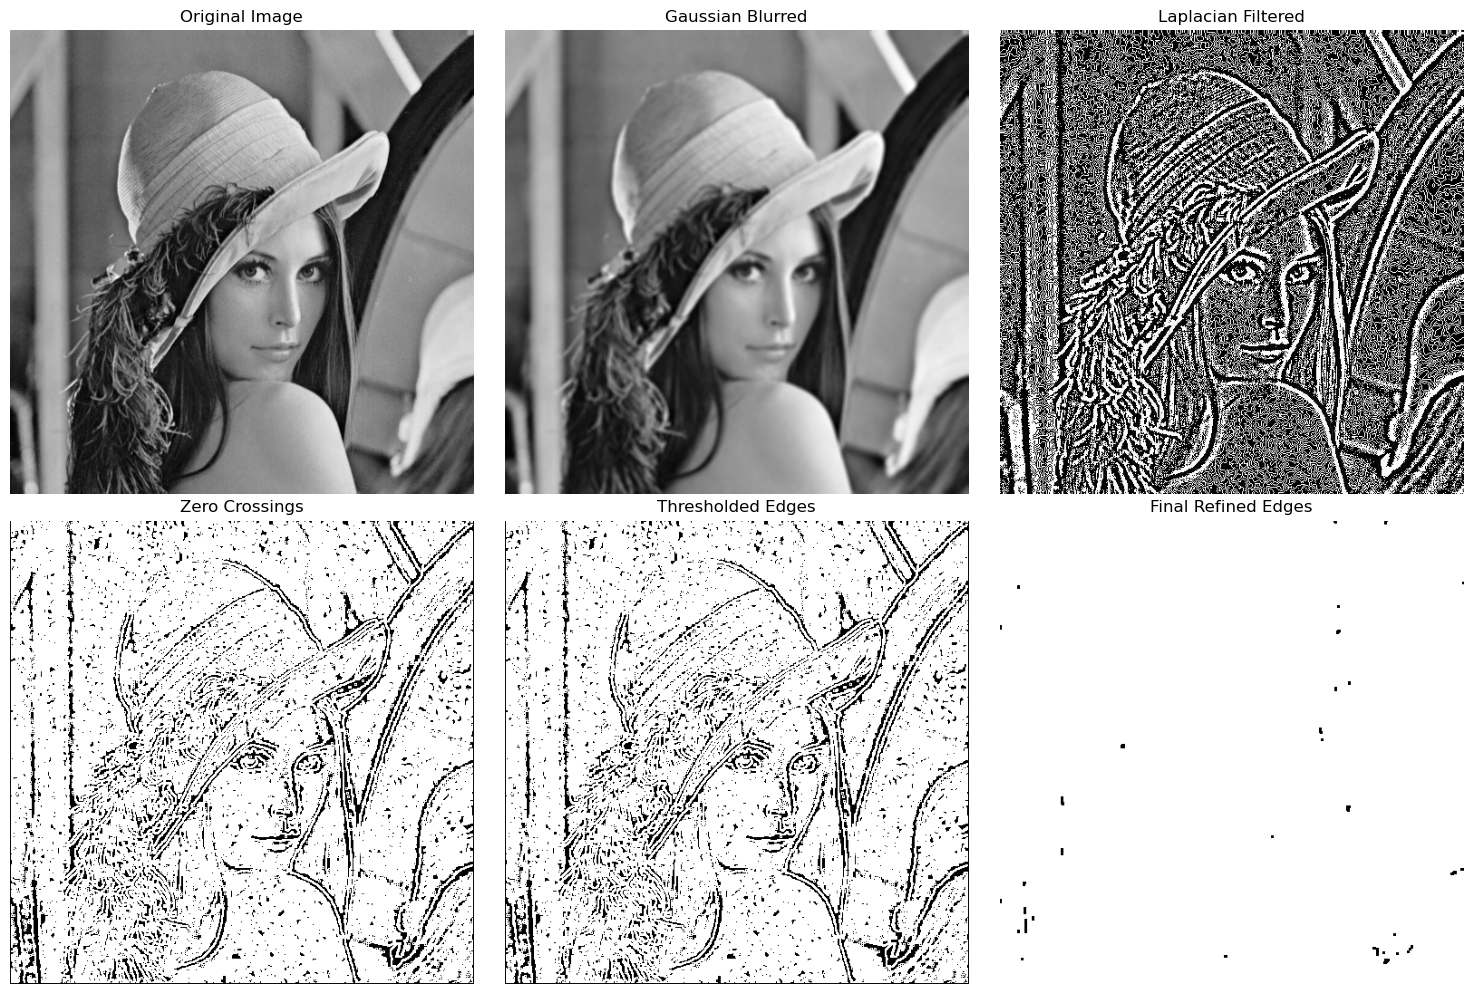

In [ ]:
from scipy.ndimage import convolve

def laplacian_of_gaussian_edge_detection(image_path, gauss_kernel=(5,5), sigma=4, laplacian_threshold=2, kernel_size=3):
    # Step 1: Load and Apply Gaussian Blur
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_img = cv2.GaussianBlur(img, gauss_kernel, sigma)

    # Step 2: Apply Laplacian Filter
    laplacian_kernel = np.array([[0, 1, 0], 
                                 [1, -4, 1], 
                                 [0, 1, 0]], dtype=np.float32)
    
    laplacian_filtered = convolve(blurred_img, laplacian_kernel)
    
    # Normalize Laplacian output
    min_val, max_val = np.min(laplacian_filtered), np.max(laplacian_filtered)
    laplacian_filtered = (laplacian_filtered - min_val) / (max_val - min_val)  # Normalize to [0, 1]

    # Step 3: Zero Crossing Detection
    rows, cols = laplacian_filtered.shape
    zero_crossings = np.zeros_like(laplacian_filtered, dtype=np.uint8)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            neg, pos = False, False
            
            neighbors = [laplacian_filtered[i-1, j], laplacian_filtered[i+1, j], 
                         laplacian_filtered[i, j-1], laplacian_filtered[i, j+1], 
                         laplacian_filtered[i-1, j-1], laplacian_filtered[i-1, j+1], 
                         laplacian_filtered[i+1, j-1], laplacian_filtered[i+1, j+1]]
            
            for neighbor in neighbors:
                if neighbor < 0.4:  # Adjust threshold based on normalization
                    neg = True
                if neighbor > 0.6:
                    pos = True

            if neg and pos:  
                zero_crossings[i, j] = 255

    # Step 4: Thresholding
    strong_edges = np.zeros_like(zero_crossings, dtype=np.uint8)
    strong_edges[zero_crossings > laplacian_threshold] = 255  

    # Step 5: Edge Refinement (Dilation & Erosion)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    refined_edges = cv2.dilate(strong_edges, kernel, iterations=2)  # Increase iterations
    refined_edges = cv2.erode(refined_edges, kernel, iterations=1)

    # Plot Results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  

    images = [img, blurred_img, laplacian_filtered, zero_crossings, strong_edges, refined_edges]
    titles = ["Original Image", "Gaussian Blurred", "Laplacian Filtered", 
              "Zero Crossings", "Thresholded Edges", "Final Refined Edges"]

    for i in range(6):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return refined_edges

image_path = "lena.png" #Replace with your image path
final_edges = laplacian_of_gaussian_edge_detection(image_path)

<h2>3)DoG(Differeniation of Gaussian)</h2>

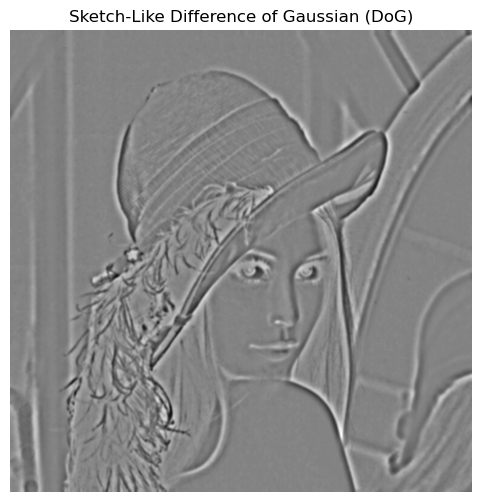

In [ ]:
def get_gaussian_kernel(size, sigma):
    k = size // 2
    y, x = np.mgrid[-k:k+1, -k:k+1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()

def manual_dog_sketch(image_path, sigma1=1, sigma2=10, kernel_size1=3, kernel_size2=15):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)

    kernel1 = get_gaussian_kernel(kernel_size1, sigma1)
    kernel2 = get_gaussian_kernel(kernel_size2, sigma2)
    
    blurred1 = convolve(img, kernel1)
    blurred2 = convolve(img, kernel2)

    # Compute Difference of Gaussian
    dog = blurred1 - blurred2

    dog = 255 - cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return dog
    
image_path = "lena.png" #Replace with your image path
dog_sketch = manual_dog_sketch(image_path)

plt.figure(figsize=(6, 6))
plt.imshow(dog_sketch, cmap='gray')
plt.title("Sketch-Like Difference of Gaussian (DoG)")
plt.axis("off")
plt.show()

<h2>4)Filters</h2>

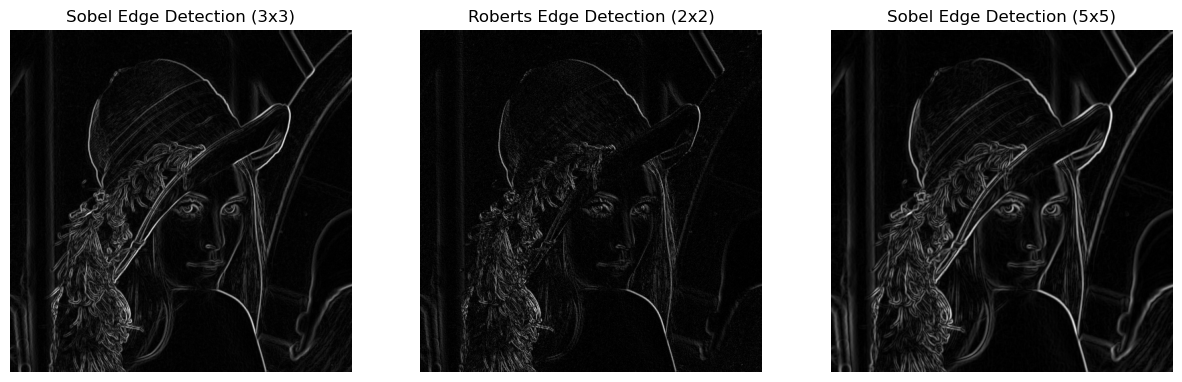

In [ ]:
def apply_filter(img, kernel):
    k_size = kernel.shape[0]
    pad = k_size // 2

    rows, cols = img.shape
    output = np.zeros((rows - 2*pad, cols - 2*pad))
    
    if k_size == 2:
        output = np.zeros((rows-1, cols-1))  # No padding needed
        for i in range(rows-1):
            for j in range(cols-1):
                region = img[i:i+2, j:j+2]
                output[i, j] = np.sum(region * kernel)
    else:
        for i in range(pad, rows - pad):
            for j in range(pad, cols - pad):
                region = img[i-pad:i+pad+1, j-pad:j+pad+1]
                output[i-pad, j-pad] = np.sum(region * kernel)

    return output

img = cv2.imread("lena.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) #Replace with your image path

# Sobel, Roberts, and Sobel-5x5 Kernels
sobel_x = np.array([[-1, -2, -1],
                    [0 ,  0,  0],
                    [1 ,  2,  1]])

sobel_y = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

robert_x = np.array([[0 ,1],
                     [-1,0]])

robert_y = np.array([[0, -1],
                     [1, 0]])

sobel5_x = np.array([[1, 2, 3, 2, 1], 
                     [2, 3, 5, 3, 2], 
                     [0, 0, 0, 0, 0],
                     [-2, -3, -5, -3, -2],
                     [-1, -2, -3, -2, -1]])

sobel5_y = np.array([[1, 2, 0, -2, -1], 
                     [2, 3, 0, -3, -2], 
                     [3, 5, 0, -5, -3],
                     [2, 3, 0, -3, -2],
                     [1, 2, 0, -2, -1]])

# Apply filters
sobel_x_res = apply_filter(img, sobel_x)
sobel_y_res = apply_filter(img, sobel_y)
robert_x_res = apply_filter(img, robert_x)
robert_y_res = apply_filter(img, robert_y)
sobel5_x_res = apply_filter(img, sobel5_x)
sobel5_y_res = apply_filter(img, sobel5_y)

# Compute gradient magnitudes
sobel_mag = np.sqrt(sobel_x_res**2 + sobel_y_res**2)
robert_mag = np.sqrt(robert_x_res**2 + robert_y_res**2)
sobel5_mag = np.sqrt(sobel5_x_res**2 + sobel5_y_res**2)

# Normalize results to 0-255
sobel_mag = (sobel_mag / sobel_mag.max()) * 255
robert_mag = (robert_mag / robert_mag.max()) * 255
sobel5_mag = (sobel5_mag / sobel5_mag.max()) * 255

# Convert to uint8
sobel_mag = sobel_mag.astype(np.uint8)
robert_mag = robert_mag.astype(np.uint8)
sobel5_mag = sobel5_mag.astype(np.uint8)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(sobel_mag, cmap='gray')
ax[0].set_title("Sobel Edge Detection (3x3)")

ax[1].imshow(robert_mag, cmap='gray')
ax[1].set_title("Roberts Edge Detection (2x2)")

ax[2].imshow(sobel5_mag, cmap='gray')
ax[2].set_title("Sobel Edge Detection (5x5)")

for a in ax:
    a.axis("off")

plt.show()